# Scenario 5: The Lac Operon

In [21]:
import numpy
import matplotlib.pyplot as plt
import json

from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.ode import OdeModel, simulate_ode_model
from mira.modeling.amr.regnet import template_model_to_regnet_json
from mira.modeling.amr.petrinet import template_model_to_petrinet_json

Define species for the model

In [22]:
i = Concept(name='i')
I = Concept(name='I')
r_I = Concept(name='r_I')
Lactose = Concept(name='Lactose')
I_Lactose = Concept(name='I_Lactose')
I_Op = Concept(name='I_Op')
Op = Concept(name='Op')
RNAP = Concept(name='RNAP')
RNAP_Op = Concept(name='RNAP_Op')
r_lac = Concept(name='r_lac')
Z = Concept(name='Z')

Define the templates for the model

In [23]:
templates = [
    ControlledProduction(controller=i, outcome=r_I).with_mass_action_rate_law('k_1'),
    ControlledProduction(controller=r_I, outcome=I).with_mass_action_rate_law('k_2'),
    *get_binding_templates('I', 'Lactose', 'I_Lactose', 'k_3', 'k_4'),
    *get_binding_templates('I', 'Op', 'I_Op', 'k_5', 'k_6'),
    *get_binding_templates('RNAP', 'Op', 'RNAP_Op', 'k_7', 'k_8'),
    NaturalDegradation(subject=RNAP_Op).with_mass_action_rate_law('k_9'),
    ControlledProduction(controller=RNAP_Op, outcome=RNAP).with_mass_action_rate_law('k_9'),
    ControlledProduction(controller=RNAP_Op, outcome=Op).with_mass_action_rate_law('k_9'),
    ControlledProduction(controller=RNAP_Op, outcome=r_lac).with_mass_action_rate_law('k_9'),
    ControlledProduction(controller=r_lac, outcome=Z).with_mass_action_rate_law('k_10'),
    ControlledDegradation(controller=Z, subject=Lactose).with_mass_action_rate_law('k_11'),
    # This term below is probably incorrect
    ControlledDegradation(controller=Lactose, subject=Z).with_mass_action_rate_law('k_11'),
    ########
    NaturalDegradation(subject=r_I).with_mass_action_rate_law('k_12'),
    NaturalDegradation(subject=I).with_mass_action_rate_law('k_13'),
    NaturalDegradation(subject=I_Lactose).with_mass_action_rate_law('k_14'),
    ControlledProduction(controller=I_Lactose, outcome=Lactose).with_mass_action_rate_law('k_14'),
    NaturalDegradation(subject=r_lac).with_mass_action_rate_law('k_15'),
    NaturalDegradation(subject=Z).with_mass_action_rate_law('k_16')
]

Define parameters and initials

In [24]:
values = [0.02, 0.1, 0.005, 0.1, 1, 0.01, 0.1, 0.01, 0.03, 0.1, 1e-5, 0.01, 0.002, 0.002, 0.01, 0.01]
parameters = {
    f'k_{idx}': Parameter(name=f'k_{idx}', value=val)
    for idx, val in enumerate(values, start=1)
}

In [25]:
initials = {
    'i_0': Initial(concept=i, expression=1.0),
    'r_I_0': Initial(concept=r_I, expression=0.0),
    'I_0': Initial(concept=I, expression=50.0),
    'Op_0': Initial(concept=Op, expression=1.0),
    'I_Op_0': Initial(concept=I_Op, expression=0.0),
    'RNAP_0': Initial(concept=RNAP, expression=100.0),
    'RNAP_Op_0': Initial(concept=RNAP_Op, expression=0.0),
    'r_lac_0': Initial(concept=r_lac, expression=0.0),
    'Z_0': Initial(concept=Z, expression=0.0),
    'I_Lactose_0': Initial(concept=I_Lactose, expression=0.0),
    'Lactose_0': Initial(concept=Lactose, expression=500.0),
}

Make the template model

In [26]:
tm = TemplateModel(templates=templates,
                   parameters=parameters,
                   initials=initials)

Prepare the model for simulation

In [27]:
om = OdeModel(Model(tm), initialized=True)
om.kinetics

Matrix([
[                                                                                                                         0],
[                                                                                        p[0, 0]*y[0, 0] - p[11, 0]*y[1, 0]],
[p[1, 0]*y[1, 0] - p[2, 0]*y[2, 0]*y[3, 0] + p[3, 0]*y[4, 0] - p[4, 0]*y[2, 0]*y[5, 0] + p[5, 0]*y[6, 0] - p[12, 0]*y[2, 0]],
[                                 -p[2, 0]*y[2, 0]*y[3, 0] + p[3, 0]*y[4, 0] - p[10, 0]*y[3, 0]*y[10, 0] + p[13, 0]*y[4, 0]],
[                                                              p[2, 0]*y[2, 0]*y[3, 0] - p[3, 0]*y[4, 0] - p[13, 0]*y[4, 0]],
[                  -p[4, 0]*y[2, 0]*y[5, 0] + p[5, 0]*y[6, 0] - p[6, 0]*y[5, 0]*y[7, 0] + p[7, 0]*y[8, 0] + p[8, 0]*y[8, 0]],
[                                                                                 p[4, 0]*y[2, 0]*y[5, 0] - p[5, 0]*y[6, 0]],
[                                                              -p[6, 0]*y[5, 0]*y[7, 0] + p[7, 0]*y[8, 0] + p

In [28]:
ts = numpy.linspace(0, 1000, 1000)
res = simulate_ode_model(om, times=ts)

Text(0, 0.5, '# Molecules / cell')

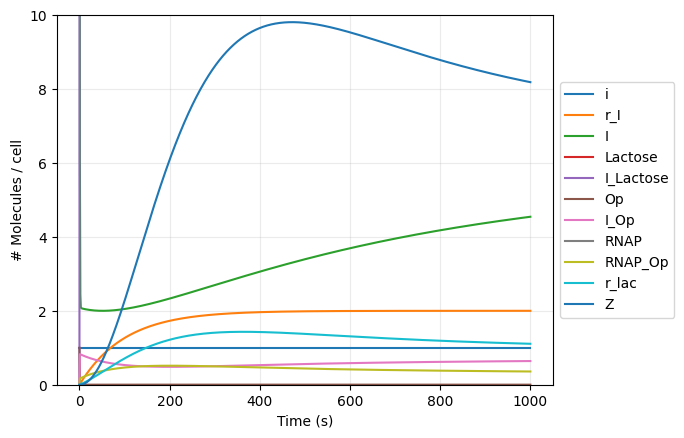

In [29]:
plt.plot(ts, res, label=om.vmap.keys())
plt.grid(alpha=0.25)
plt.ylim([0, 10])
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('# Molecules / cell')

## Export the model into different frameworks

In [30]:
frameworks = {'regnet': template_model_to_regnet_json, 'petrinet': template_model_to_petrinet_json}

for fkey, fun in frameworks.items():
    with open(f'scenario5_{fkey}.json', 'w') as fh:
        json.dump(fun(tm), fh, indent=1)